In [72]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cmasher as cmr

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [ ]:
mwstreams = galstreams.MWStreams()

In [201]:
from ezpadova import parsec

Z = 10 ** (-2.2 + np.log10(0.0207))
iso = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="panstarrs1")
iso = iso.to_astropy_table()

iso_gaia = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="gaia")
iso_gaia = iso_gaia.to_astropy_table()
iso_gaia.remove_columns([x for x in iso_gaia.colnames if x in iso.colnames])

iso = at.hstack((iso, iso_gaia))

tmp_iso = iso[iso["stage"] == 4][1:]
HB_absmag = np.mean(tmp_iso["rP1"])

tmp_iso = iso[iso["stage"] == 1]
MSTO_absmag = tmp_iso["rP1"].min()

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


## Load data:

In [2]:
# tbl = at.Table.read("../data/Ibata2023_Table1.csv")
g = GaiaData(
    "../data/Ibata2023_GaiaDR3-xm.fits",
    radial_velocity_colname="vh",
    radial_velocity_unit=u.km / u.s,
)

In [18]:
tbl = at.Table.read("../data/ibata_streams_full.csv")
sID_to_name = {row["sID"]: row["name"] for row in at.unique(tbl, keys="sID")}

In [219]:
dist = g.get_distance(allow_negative=True)
dist[~np.isfinite(dist)] = 100 * u.kpc

c = g.get_skycoord(distance=dist)
# c = coord.SkyCoord(
#     ra=tbl["ra"] * u.deg,
#     dec=tbl["dec"] * u.deg,
#     distance=dist,
#     pm_ra_cosdec=tbl["mu_r"] * u.mas / u.yr,
#     pm_dec=tbl["mu_d"] * u.mas / u.yr,
#     radial_velocity=tbl["vh"] * u.km / u.s,
# )

In [22]:
gal = c.galactic

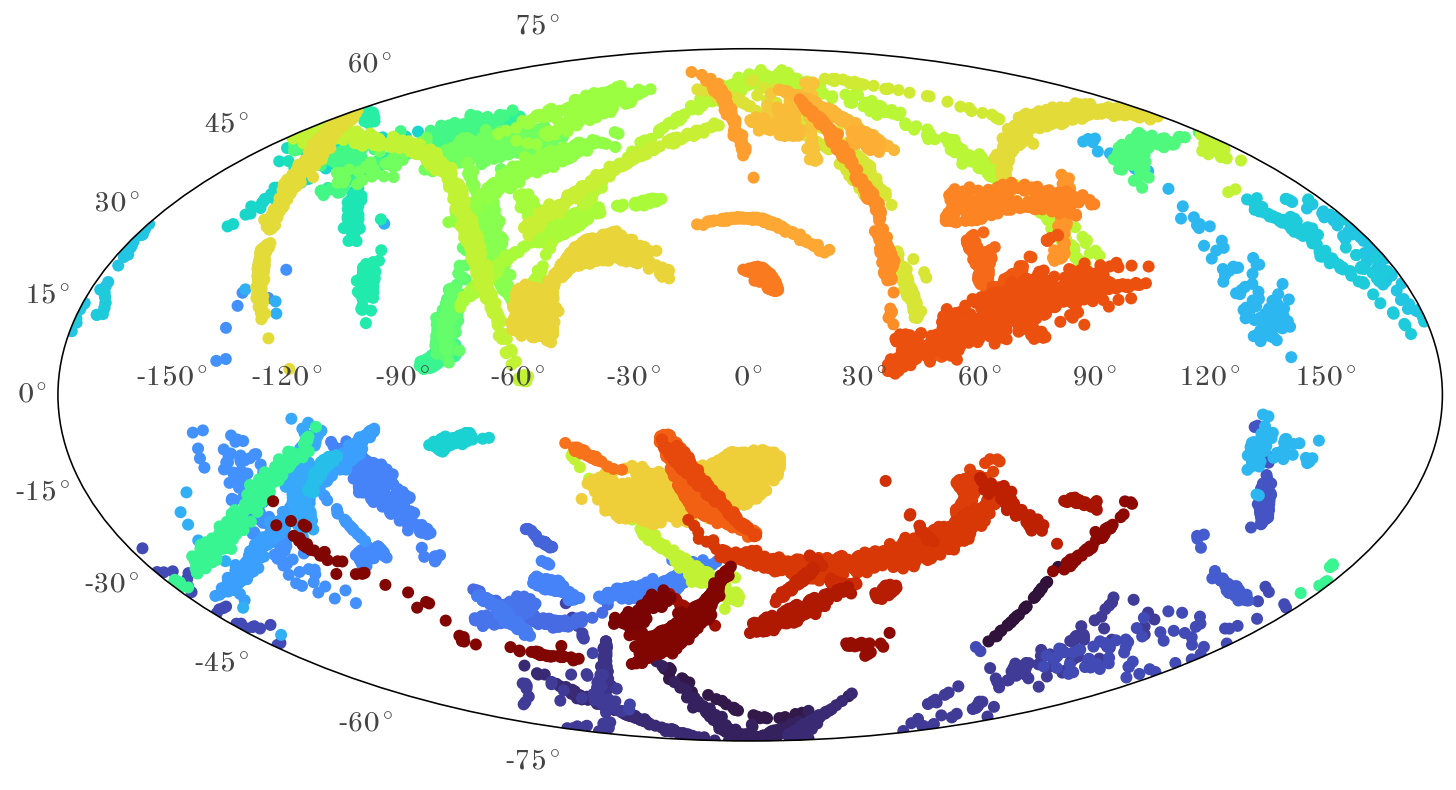

In [23]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, c=tbl["sID"], cmap="turbo")

In [319]:
def get_frame_from_points(c):
    """
    Parameters
    ----------
    c : astropy.coordinates.SkyCoord
        Must have sky coordinates for a set of stars.
    """
    u_xyz = (
        c.data.represent_as(coord.UnitSphericalRepresentation).to_cartesian().xyz.value
    )

    # Initial guess of the direction that the stream spreads in, based on eigenvectors:
    eig_res = np.linalg.eig(np.cov(u_xyz))

    proj = u_xyz.T @ eig_res.eigenvectors[:, 0]
    idx = np.argsort(proj)
    frame = gc.GreatCircleICRSFrame.from_endpoints(c[idx[0]], c[idx[-1]])

    # Now we will make fine adjustments to the orientation of the frame to get the
    # stream to lie near phi2=0

    # The initial rotation matrix from the endpoints above:
    R = np.zeros((3, 3))
    R[0] = frame.origin.cartesian.xyz
    R[2] = frame.pole.cartesian.xyz
    R[1] = np.cross(R[:, 0], R[:, 2])

    def frame_adjust(rot_x, rot_y):
        Rx = coord.matrix_utilities.rotation_matrix(rot_x * u.deg, "x")
        Ry = coord.matrix_utilities.rotation_matrix(rot_y * u.deg, "y")
        new_R = Rx @ Ry @ R
        return gc.GreatCircleICRSFrame.from_R(new_R)

    def objective(p):
        new_frame = frame_adjust(p[0], p[1])
        c_fr = c.transform_to(new_frame)
        return np.sum(c_fr.phi2.degree**2)

    res = minimize(objective, x0=[0.0, 0.0], bounds=[[-30, 30], [-20, 20]])
    return frame_adjust(*res.x)

In [350]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)


def get_w0_from_p(p, frame):
    # At phi1 = 0.
    orbit_w0_fr = coord.SkyCoord(
        phi1=0 * u.deg,
        phi2=p["phi2"] * u.deg,
        distance=p["distance"] * u.kpc,
        pm_phi1_cosphi2=p["pmphi1"] * u.mas / u.yr,
        pm_phi2=p["pmphi2"] * u.mas / u.yr,
        radial_velocity=p["rv"] * u.km / u.s,
        frame=frame,
    )
    orbit_w0_galcen = orbit_w0_fr.transform_to(galcen_frame)
    return gd.PhaseSpacePosition(orbit_w0_galcen.data)


def p_arr_to_dict(p):
    return {
        "phi2": p[0],
        "distance": p[1],
        "pmphi1": p[2],
        "pmphi2": p[3],
        "rv": p[4],
    }


def get_orbit(mw, orbit_w0, int_time):
    orbit1 = mw.integrate_orbit(orbit_w0, dt=-0.5, t1=0, t2=-2 * int_time)
    orbit2 = mw.integrate_orbit(orbit_w0, dt=0.5, t1=0, t2=2 * int_time)

    orbit_xyz = np.hstack((orbit1[::-1].xyz, orbit2[1:].xyz))
    orbit_vxyz = np.hstack((orbit1[::-1].v_xyz, orbit2[1:].v_xyz))
    orbit_t = np.concatenate((orbit1[::-1].t, orbit2.t[1:]))
    orbit = gd.Orbit(orbit_xyz, orbit_vxyz, t=orbit_t)[::-1]
    return orbit


def get_orbit_from_p(mw, p, c_fr):
    phi1_size = c_fr.phi1.radian.max() - c_fr.phi1.radian.min()
    orbit_w0 = get_w0_from_p(p, c_fr.frame)

    # Old way:
    # int_time = (
    #     (phi1_size * p["distance"] * u.kpc) / np.linalg.norm(orbit_w0.v_xyz)
    # ).to(u.Myr)
    int_time = (
        (phi1_size * u.radian)
        / (np.sqrt(p["pmphi1"] ** 2 + p["pmphi2"] ** 2) * u.mas / u.yr)
    ).to_value(u.Myr)
    int_time = np.max([int_time, 100.0]) * u.Myr

    orbit = get_orbit(mw, orbit_w0, int_time)
    return orbit


def cut_wrapped_orbit(orbit, orbit_fr):
    idx = np.where(np.abs(np.diff(orbit_fr.phi1.wrap_at(180 * u.deg).degree)) > 180)[0]

    orbit_mask = np.ones(orbit.ntimes, dtype=bool)
    for i in idx:
        wrap_time = orbit.t[i]
        if wrap_time > 0:
            orbit_mask &= orbit.t < wrap_time
        else:
            orbit_mask &= orbit.t > wrap_time
    return orbit[orbit_mask], orbit_fr[orbit_mask]


def ln_likelihood(p, c_fr, data, mw):
    orbit = get_orbit_from_p(mw, p, c_fr)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)

    # if the orbit wraps, need to cut it off at +/- 180º!
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)

    # fig, ax = plt.subplots()
    # ax.plot(orbit.t.value[1:], np.diff(orbit_fr.phi1.degree))

    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.scatter(c_fr.phi1.degree, c_fr.phi2.degree, s=3)
    # ax.plot(orbit_fr.phi1.degree, orbit_fr.phi2.degree, marker='')

    interps = {}
    units = {}
    for name in ["phi2", "distance", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]:
        comp = getattr(orbit_fr, name)
        x = orbit_fr.phi1.wrap_at(180 * u.deg).degree
        idx = np.argsort(x)
        interps[name] = InterpolatedUnivariateSpline(x[idx], comp[idx], k=3)
        units[name] = comp.unit

    ll = 0.0
    for name in interps:
        if name == "phi2":
            err = 0.05
        elif name == "distance":
            err = data["parallax_error"]
        else:
            err = data[f"{name}_error"]

        model_y = interps[name](c_fr.phi1.wrap_at(180 * u.deg).degree)

        if name == "distance":
            y = data["parallax"]
            model_y = c_fr.distance.parallax.to_value(u.mas)
        else:
            y = getattr(c_fr, name).to_value(units[name])
        ll += -0.5 * (model_y - y) ** 2 / err**2

    return ll

## Fit orbits:

In [352]:
def objective(p, *args, **kwargs):
    p = p_arr_to_dict(p)
    lls = ln_likelihood(p, *args, **kwargs)
    return -np.sum(lls) / len(lls)

In [353]:
mw = gp.MilkyWayPotential2022()

In [374]:
data_file = pathlib.Path("../data/stream-orbit-fits.pkl")

if not data_file.exists():
    all_data = {}

    for sid in tqdm(np.unique(tbl["sID"])):
        # print(sID_to_name[sid])
        mask = tbl["sID"] == sid
        rows = g[mask]

        frame = get_frame_from_points(c[mask])
        c_fr = c[mask].transform_to(frame)

        C, _ = rows.get_cov(coords=["pmra", "pmdec"])
        C_pm_fr = gc.transform_pm_cov(c[mask], C, frame)
        pm1_err = np.sqrt(C_pm_fr[:, 0, 0])
        pm2_err = np.sqrt(C_pm_fr[:, 1, 1])
        obj_data = {
            "parallax": rows.parallax.value,
            "parallax_error": rows.parallax_error.value,
            "pm_phi1_cosphi2_error": pm1_err,
            "pm_phi2_error": pm2_err,
            "radial_velocity_error": rows.evh,
        }

        idx = np.argsort(np.abs(c_fr.phi1.wrap_at(180 * u.deg).degree))
        phi2 = np.nanmedian(c_fr.phi2.to_value(u.deg)[idx][:8])
        pm_phi1 = np.nanmean(c_fr.pm_phi1_cosphi2[idx][:8])
        pm_phi2 = np.nanmean(c_fr.pm_phi2[idx][:8])
        rv = np.nanmean(rows["vh"][rows["vh"] != 0.0])

        init_dists = np.geomspace(1, 40, 6)
        reses = []
        for d0 in init_dists:
            p0 = {
                "phi2": phi2,
                "distance": d0,
                "pmphi1": pm_phi1.value,
                "pmphi2": pm_phi2.value,
                "rv": rv.value,
            }
            try:
                res = minimize(
                    objective,
                    list(p0.values()),
                    bounds=[[-5, 5], [0.5, 50], [-100, 100], [-100, 100], [-500, 500]],
                    args=(c_fr, obj_data, mw),
                    method="L-BFGS-B",
                    options={"ftol": 1e-10, "gtol": 1e-10},
                )
            except Exception as err:
                print(f"{sid} failed with an exception: ")
                print(err)
                continue

            if not res.success:
                continue

            reses.append(res)

        if len(reses) == 0:
            print(f"{sid} failed: {res.nit}")
            continue
        elif len(reses) == 1:
            res = reses[0]
        else:
            i = np.argmin([r.fun for r in reses])
            res = reses[i]

        res_p = p_arr_to_dict(res.x)
        orbit = get_orbit_from_p(mw, res_p, c_fr)
        orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)

        # Store stuff:
        this_data = {}
        this_data["c_fr"] = c_fr
        this_data["obj_data"] = obj_data
        this_data["p"] = res_p
        this_data["orbit"] = orbit
        this_data["orbit_fr"] = orbit_fr
        all_data[sid] = this_data

    with open(data_file, "wb") as f:
        pickle.dump(all_data, f)

else:
    with open(data_file, "rb") as f:
        all_data = pickle.load(f)

  0%|          | 0/87 [00:00<?, ?it/s]

/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:1838: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)


56 failed with an exception: 
x must be increasing if s > 0
56 failed with an exception: 
x must be increasing if s > 0
56 failed with an exception: 
x must be increasing if s > 0
56 failed with an exception: 
x must be increasing if s > 0
56 failed with an exception: 
x must be increasing if s > 0
56 failed with an exception: 
x must be increasing if s > 0
56 failed: 72


In [380]:
def make_components_plot(orbit, orbit_fr, c_fr, obj_data):
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)

    comps = ["phi2", "parallax", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]
    fig, axes = plt.subplots(
        len(comps), 1, figsize=(8, len(comps) * 2.5), sharex=True, layout="constrained"
    )
    err_style = dict(ls="none", marker="o", ms=3, color="k")
    for i, name in enumerate(comps):
        ax = axes[i]
        if name == "parallax":
            ax.plot(
                orbit_fr.phi1.degree,
                orbit_fr.distance.parallax.to_value(u.mas),
                marker="",
                color="tab:blue",
            )
            ax.errorbar(
                c_fr.phi1.degree,
                obj_data["parallax"],
                obj_data["parallax_error"],
                **err_style,
            )

        else:
            ax.plot(
                orbit_fr.phi1.degree,
                getattr(orbit_fr, name).value,
                marker="",
                color="tab:blue",
            )

            y = getattr(c_fr, name).value
            y_mask = ~np.isclose(y, 0.0)
            if f"{name}_error" in obj_data:
                ax.errorbar(
                    c_fr.phi1.degree[y_mask],
                    y[y_mask],
                    obj_data[f"{name}_error"][y_mask],
                    **err_style,
                )
            else:
                ax.scatter(c_fr.phi1.degree[y_mask], y[y_mask], s=3)

        ax.set_ylabel(name)
    ax.set_xlim(-100, 100)
    axes[-1].set_xlabel("phi1")
    return fig, axes

In [381]:
plot_path = pathlib.Path("../plots").resolve()
plot_path.mkdir(exist_ok=True)

for sid, this_data in all_data.items():
    fig, _ = make_components_plot(
        this_data["orbit"],
        this_data["orbit_fr"],
        this_data["c_fr"],
        this_data["obj_data"],
    )
    fig.suptitle(sID_to_name[sid], fontsize=20)
    fig.savefig(plot_path / f"stream-{sid:04d}-orbitfit.png", dpi=200)
    plt.close(fig)

In [90]:
fit_tbl = at.Table(
    [{"sID": sid, "name": sID_to_name[sid], **d["p"]} for sid, d in all_data.items()]
)

From visual inspection of plots:

In [382]:
failed = [
    21,
    48,  # Orphan
    77,
]

In [405]:
pre_gaia_ibata = ["Orphan", "GD-1", "NGC5466", "Pal5", "Ophiuchus", "Jhelum", "Tuc3"]

## S5 streams:
s5_streams = "300S", "Willka Yaku", "AAU", "Jet", "Phoenix", "Indus", "Palca", "Elqui", "Turranburra",

Distance modulus functions are from Li et al 2022, Table 1

In [390]:
# mwstreams["Elqui-S19"]
# mwstreams["Turranburra-S19"]

In [412]:
stream = mwstreams["300S-F18"]
stream.ref

'fu2018'

In [402]:
rows = []

stream = mwstreams["300S-F18"]
track = stream.track.transform_to(stream.stream_frame)
rows.append(
    {
        "name": "300S",
        "phi1": track.phi1.wrap_at(180 * u.deg).degree,
        "distmod": 48.9952 - 0.2083 * stream.track.ra.degree,
    }
)

stream = mwstreams["Willka_Yaku-S18"]
track = stream.track.transform_to(stream.stream_frame)
rows.append(
    {
        "name": "Willka Yaku",
        "phi1": track.phi1.wrap_at(180 * u.deg).degree,
        "distmod": np.full(len(track), 17.8),
    }
)

stream = mwstreams["AAU-ATLAS-L21"]
track_phi1 = np.concatenate(
    (
        mwstreams["AAU-ATLAS-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi1.wrap_at(180 * u.deg)
        .degree,
        mwstreams["AAU-AliqaUma-L21"]
        .track.transform_to(mwstreams["AAU-ATLAS-L21"].stream_frame)
        .phi1.wrap_at(180 * u.deg)
        .degree,
    )
)
rows.append(
    {"name": "AAU", "phi1": track_phi1, "distmod": 16.67 - 0.034 * track_phi1}
)

stream = mwstreams["Jet-F22"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Jet", "phi1": track_phi1, "distmod": 17.45 - 0.014 * track_phi1}
)

stream = mwstreams["Phoenix-S19"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Phoenix", "phi1": track_phi1, "distmod": 16.26 + 0.008 * track_phi1}
)

stream = mwstreams["Indus-S19"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Indus", "phi1": track_phi1, "distmod": 15.90 - 0.016 * track_phi1}
)

stream = mwstreams["Palca-S18"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Palca", "phi1": track_phi1, "distmod": np.full_like(track_phi1, 17.8)}
)

stream = mwstreams["Elqui-S19"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Elqui", "phi1": track_phi1, "distmod": 18.48 - 0.043 * track_phi1}
)

stream = mwstreams["Turranburra-S19"]
track_phi1 = stream.track.transform_to(stream.stream_frame).phi1.wrap_at(180 * u.deg).degree
rows.append(
    {"name": "Turranburra", "phi1": track_phi1, "distmod": np.full_like(track_phi1, 17.1)}
)

s5_data = at.Table(rows)

---

In [406]:
pre_gaia_colors = cmr.get_sub_cmap("cmr.infinity", 0.0, 0.5, N=len(pre_gaia) + len(s5_data)).colors
other_colors = cmr.get_sub_cmap(
    "cmr.infinity", 0.5, 1.0, N=len(all_data) - len(pre_gaia_ibata)
).colors

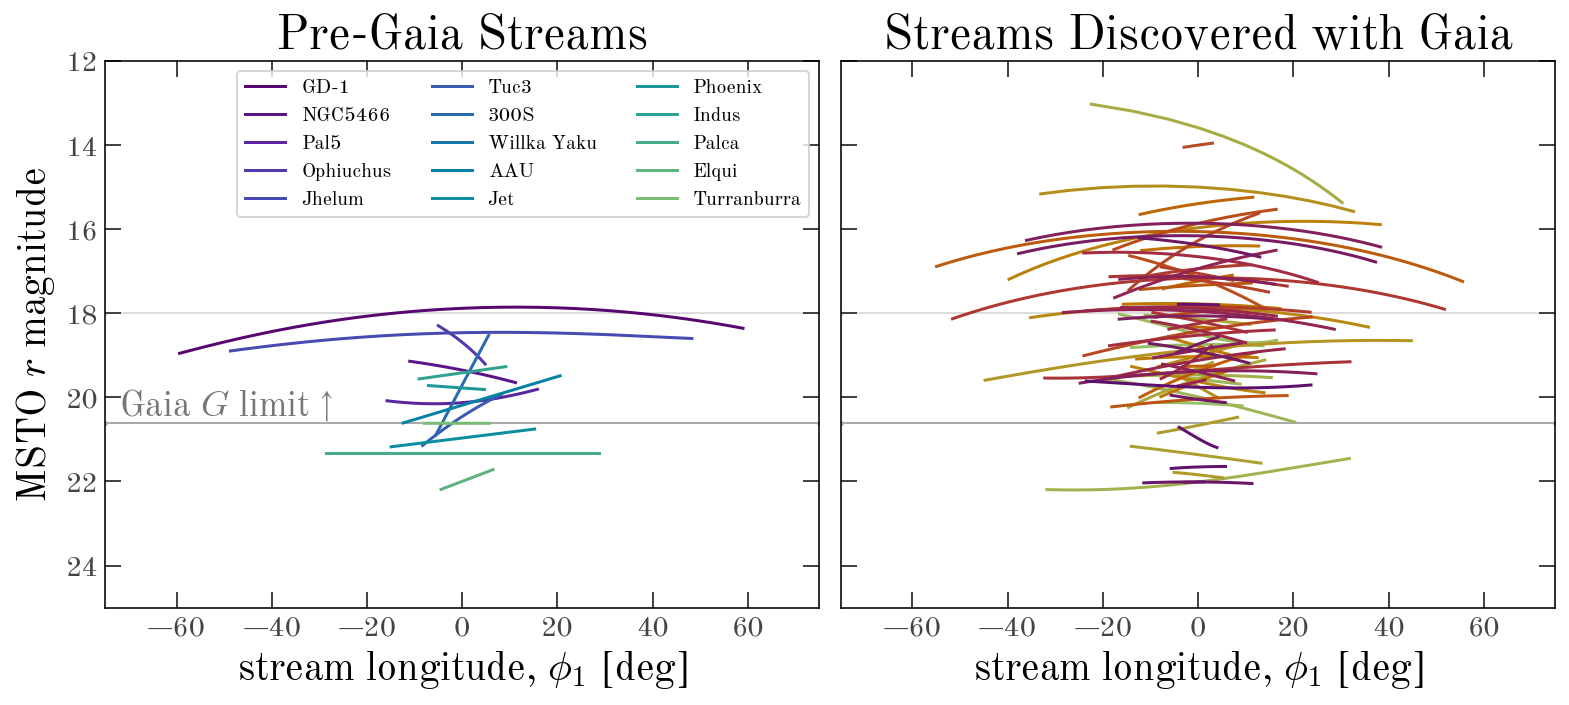

In [410]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), layout="tight", sharex=True, sharey=True
)

pg_i = 0
oth_i = 0
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree > phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree < phi1_lim[1]
    )

    DM = d["orbit_fr"].distance.distmod.value
    HB_r = DM + HB_absmag
    MSTO_r = DM + MSTO_absmag

    if name in pre_gaia_ibata:
        ax = axes[0]
        c = pre_gaia_colors[pg_i]
        pg_i += 1
    else:
        ax = axes[1]
        c = other_colors[oth_i]
        oth_i += 1
    ax.plot(
        d["orbit_fr"].phi1.degree[orbit_phi1_mask],
        MSTO_r[orbit_phi1_mask],
        marker="",
        label=f"{name}",
        color=c,
    )

for pg_i, row in enumerate(s5_data, start=pg_i):
    c = pre_gaia_colors[pg_i]
    ax.plot(
        row["phi1"],
        row["distmod"] + MSTO_absmag,
        marker="",
        label=f"{row['name']}",
        color=c,
    )

axes[0].legend(ncols=3)

ax.set_xlim(-75, 75)
ax.set_ylim(25, 12)

for ax in axes:
    ax.set_xlabel(r"stream longitude, $\phi_1$ [deg]")
    # ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
    ax.axhline(20.6, linewidth=1, zorder=-100, color="#aaaaaa")
    ax.axhline(18, linewidth=1, zorder=-100, color="#dddddd")

axes[0].text(
    ax.get_xlim()[0] + 3,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].set_title("Pre-Gaia Streams")
axes[1].set_title("Streams Discovered with Gaia")
axes[0].set_ylabel("MSTO $r$ magnitude")

fig.savefig("../tex/figures/msto-rc-mag.pdf")